## Preis' Strategy

#### Importing notebooks

In [1]:
%%capture
%run '01. Data Retrieval.ipynb'

#### Settings

In [2]:
#disable warnings for chained assigments
pandas.options.mode.chained_assignment = None

Source code has been chiefly replicated from:

https://github.com/twiecki/replicate_google_trends/blob/master/goog_repl.ipynb

(Last Accessed 26 January 2018)

#### Functions

In [3]:
#function to be used later
def calculate_returns(delta_time_in_days):
    
    data['order'] = 0
    
    #rolling mean for delta_time_in_days
    #shift(1), so value gets written to the 'delta_time_in_daysth' row
    data['rolling_mean_search_volume']  = data['search_volume'].\
    rolling(delta_time_in_days).mean().shift(1)
    
    #if search_volume > rolling_mean_search_volume -> set sell signal
    data['order'][data.search_volume > data.rolling_mean_search_volume.shift(1)] = -1

    #if search_volume < rolling_mean_search_volume -> set buy signal
    data['order'][data.search_volume < data.rolling_mean_search_volume.shift(1)] = 1
    
    #calculates daily returns for both google-trends-based strategy
    #and buy and hold strategy.
    #log because time additive:
    #explained here: https://www.youtube.com/watch?v=PtoUlt3V0CI 
    data['google_returns'] = data.order * numpy.log(data.bitcoin_price.shift(-1))\
    - data.order * numpy.log(data.bitcoin_price)
    data['buy_hold_returns'] = numpy.log(data.bitcoin_price.shift(-1))\
    - numpy.log(data.bitcoin_price)
    
    #calculates total and return.
    #subtract by initial investment which is -100%
    data['total_google_returns'] = numpy.exp(data.google_returns.cumsum()) - 1
    data['total_buy_hold_returns'] = numpy.exp(data.buy_hold_returns.cumsum()) -1

    return data

### 1. Find most lucrative delta_time in days

In [4]:
#calculate all returns for all delta_time_limit up to 30 days
#and store in its own dataframe.
delta_time_limit = 30

index = list(range(1, delta_time_limit+1))

#init dataframe
google_based_return = pandas.DataFrame(index=index, columns=['return in percent'])
google_based_return = google_based_return.fillna(0.0)
google_based_return.index.name = 'time_period_in_days'

#do calculation
for value in index:        
    data = calculate_returns(value)
    #iloc -2 gets last valid value
    google_based_return['return in percent'][value] = \
    data['total_google_returns'].iloc[-2]    
    
google_based_return.head()

,return in percent
time_period_in_days,
1,8.183209
2,7.082759
3,10.593672
4,8.745960
5,-0.060275


In [5]:
#buy and hold return (irrespective )
data['total_buy_hold_returns'].iloc[-2]

2563.0236062114659

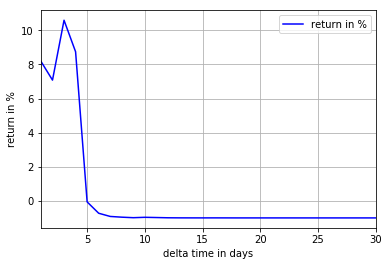

In [6]:
#plot for returns dependant of delta time in days. Peak at day 3.
#a delta time of 3 days brings highest return
ax = google_based_return.plot(color='b')
ax.grid()
ax.set_xlabel('delta time in days')
ax.set_ylabel('return in %')
ax.legend(('return in %',), loc=0) #loc 0: best

In [7]:
max_delta = max(google_based_return.idxmax())
max_delta

3

### 2. Comparison of Google-Trends based strategy with Buy and Hold strategy

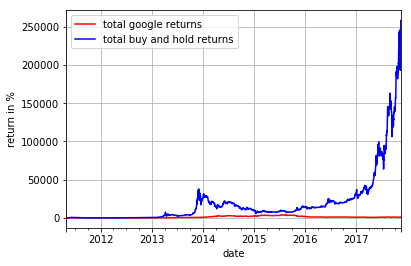

In [8]:
#plot returns
data = calculate_returns(max_delta)

ax = (data['total_google_returns']*100).plot(color='r')
ax = (data['total_buy_hold_returns']*100).plot(color='b')
ax.grid()
ax.set_xlabel('date')
ax.set_ylabel('return in %')
ax.legend(('total google returns', 'total buy and hold returns'), loc=2)